In [22]:
#==============================================================================
# CELL 1: IMPORT LIBRARIES
#==============================================================================
"""
Import semua libraries yang dibutuhkan untuk hyperparameter tuning.
"""
# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV, 
    cross_val_score, 
    StratifiedKFold,
    cross_validate
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef,
    balanced_accuracy_score, make_scorer
)

# Statistical testing
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import json
import os
import joblib
from datetime import datetime
import time

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['savefig.dpi'] = 300
sns.set_style("whitegrid")
sns.set_palette("husl")

print("="*80)
print("FASE 4: HYPERPARAMETER TUNING & MODEL OPTIMIZATION")
print("="*80)
print("\n✅ All libraries imported successfully!")
print("="*80)

FASE 4: HYPERPARAMETER TUNING & MODEL OPTIMIZATION

✅ All libraries imported successfully!


In [23]:
#==============================================================================
# CELL 2: LOAD DATA & BASELINE MODEL
#==============================================================================
"""
Load preprocessed data dan baseline model untuk comparison.
"""
print("\n" + "="*80)
print("📂 LOADING DATA & BASELINE MODEL")
print("="*80)

# Load training data
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()

# Load test data
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# Load baseline model
baseline_model = joblib.load('../models/baseline_rf_model.pkl')

# Load baseline metrics
with open('../results/metrics/03_baseline_metrics.json', 'r') as f:
    baseline_metrics = json.load(f)

print("\n✅ Data Loaded:")
print(f"  • Training samples: {len(X_train)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Features: {X_train.shape[1]}")
print(f"  • Feature names: {X_train.columns.tolist()}")

print("\n✅ Class Distribution:")
train_dist = Counter(y_train)
test_dist = Counter(y_test)
print(f"  • Training: Class 0={train_dist[0]}, Class 1={train_dist[1]} (ratio: {train_dist[0]/train_dist[1]:.2f})")
print(f"  • Test: Class 0={test_dist[0]}, Class 1={test_dist[1]} (ratio: {test_dist[0]/test_dist[1]:.2f})")

print("\n✅ Baseline Model Performance (Recap):")
print(f"  • Test Accuracy: {baseline_metrics['test_metrics']['accuracy']:.4f}")
print(f"  • Test ROC-AUC: {baseline_metrics['test_metrics']['roc_auc']:.4f}")
print(f"  • Test F1-Score: {baseline_metrics['test_metrics']['f1_score']:.4f}")
print(f"  • Training Time: {baseline_metrics['model_info']['training_time_seconds']:.2f}s")

# Get baseline predictions for later comparison
y_test_pred_baseline = baseline_model.predict(X_test)

print("\n" + "="*80)


📂 LOADING DATA & BASELINE MODEL

✅ Data Loaded:
  • Training samples: 1508
  • Test samples: 377
  • Features: 24
  • Feature names: ['Age_Encoded', 'Gender_Encoded', 'Education_Encoded', 'country_Australia', 'country_Canada', 'country_New Zealand', 'country_Other', 'country_Republic of Ireland', 'country_UK', 'country_USA', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Mixed-Black/Asian', 'ethnicity_Mixed-White/Asian', 'ethnicity_Mixed-White/Black', 'ethnicity_Other', 'ethnicity_White', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']

✅ Class Distribution:
  • Training: Class 0=568, Class 1=940 (ratio: 0.60)
  • Test: Class 0=142, Class 1=235 (ratio: 0.60)

✅ Baseline Model Performance (Recap):
  • Test Accuracy: 0.8647
  • Test ROC-AUC: 0.9271
  • Test F1-Score: 0.8898
  • Training Time: 0.47s



In [24]:
#==============================================================================
# CELL 3: DEFINE HYPERPARAMETER SEARCH SPACE
#==============================================================================
"""
Define comprehensive hyperparameter search space untuk RandomizedSearchCV.
"""
print("\n" + "="*80)
print("🔧 DEFINING HYPERPARAMETER SEARCH SPACE")
print("="*80)

# Hyperparameter distributions
param_distributions = {
    # Number of trees
    'n_estimators': [100, 200, 300, 500, 1000],
    
    # Tree depth (add constraint to reduce overfitting)
    'max_depth': [10, 20, 30, 40, None],
    
    # Minimum samples to split a node (increase to reduce overfitting)
    'min_samples_split': [2, 5, 10, 20],
    
    # Minimum samples at leaf node
    'min_samples_leaf': [1, 2, 4, 8],
    
    # Number of features for best split
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    
    # Bootstrap sampling
    'bootstrap': [True, False],
    
    # Class weights (for handling imbalance)
    'class_weight': ['balanced', 'balanced_subsample', None],
    
    # Split criterion
    'criterion': ['gini', 'entropy']
}

print("\n✅ Search Space Defined:")
for param, values in param_distributions.items():
    print(f"  • {param:20s}: {values}")

# Calculate total combinations
total_combinations = 1
for values in param_distributions.values():
    total_combinations *= len(values)

print(f"\n✅ Total possible combinations: {total_combinations:,}")
print(f"✅ RandomizedSearchCV will sample: 100 combinations")
print(f"✅ With 5-fold CV: 100 × 5 = 500 model fits")
print(f"✅ Estimated time: 10-30 minutes (depending on hardware)")

print("\n" + "="*80)


🔧 DEFINING HYPERPARAMETER SEARCH SPACE

✅ Search Space Defined:
  • n_estimators        : [100, 200, 300, 500, 1000]
  • max_depth           : [10, 20, 30, 40, None]
  • min_samples_split   : [2, 5, 10, 20]
  • min_samples_leaf    : [1, 2, 4, 8]
  • max_features        : ['sqrt', 'log2', 0.3, 0.5]
  • bootstrap           : [True, False]
  • class_weight        : ['balanced', 'balanced_subsample', None]
  • criterion           : ['gini', 'entropy']

✅ Total possible combinations: 19,200
✅ RandomizedSearchCV will sample: 100 combinations
✅ With 5-fold CV: 100 × 5 = 500 model fits
✅ Estimated time: 10-30 minutes (depending on hardware)



In [25]:
#==============================================================================
# CELL 4: RANDOMIZED SEARCH CV
#==============================================================================
"""
Perform RandomizedSearchCV untuk find optimal hyperparameters.
PALING LAMA: 10-30 menit tergantung hardware!
"""
print("\n" + "="*80)
print("🔍 HYPERPARAMETER TUNING - RANDOMIZED SEARCH CV")
print("="*80)

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize base Random Forest
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=0
)

# Initialize RandomizedSearchCV
print("\n⚙️  Setting up RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=100,  # Sample 100 combinations
    scoring='roc_auc',  # Optimize for ROC-AUC as per proposal
    cv=cv_strategy,
    verbose=2,  # Show progress
    random_state=42,
    n_jobs=-1,  # Parallel processing
    return_train_score=True
)

print("\n✅ RandomizedSearchCV Configuration:")
print(f"  • Estimator: RandomForestClassifier")
print(f"  • n_iter: 100 (sample 100 combinations)")
print(f"  • Scoring: roc_auc")
print(f"  • CV: 5-fold Stratified")
print(f"  • n_jobs: -1 (all cores)")
print(f"  • Total fits: 100 × 5 = 500")

# Perform hyperparameter search
print("\n🚀 Starting hyperparameter search...")
print("⏱️  This will take 10-30 minutes depending on your hardware...")
print("-"*80)

start_time = time.time()
random_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

print("\n" + "="*80)
print(f"✅ HYPERPARAMETER TUNING COMPLETED!")
print(f"⏱️  Total time: {tuning_time/60:.2f} minutes ({tuning_time:.0f} seconds)")
print("="*80)


🔍 HYPERPARAMETER TUNING - RANDOMIZED SEARCH CV

⚙️  Setting up RandomizedSearchCV...

✅ RandomizedSearchCV Configuration:
  • Estimator: RandomForestClassifier
  • n_iter: 100 (sample 100 combinations)
  • Scoring: roc_auc
  • CV: 5-fold Stratified
  • n_jobs: -1 (all cores)
  • Total fits: 100 × 5 = 500

🚀 Starting hyperparameter search...
⏱️  This will take 10-30 minutes depending on your hardware...
--------------------------------------------------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits

✅ HYPERPARAMETER TUNING COMPLETED!
⏱️  Total time: 4.31 minutes (259 seconds)


In [26]:
#==============================================================================
# CELL 5: BEST HYPERPARAMETERS
#==============================================================================
"""
Extract dan display best hyperparameters found.
"""
print("\n" + "="*80)
print("🏆 BEST HYPERPARAMETERS FOUND")
print("="*80)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("\n✅ Best Parameters:")
print("-"*80)
for param, value in sorted(best_params.items()):
    print(f"  • {param:20s}: {value}")

print(f"\n✅ Best Cross-Validation Score:")
print(f"  • ROC-AUC: {best_score:.4f}")

# Get best model
best_rf_model = random_search.best_estimator_

print(f"\n✅ Best Model Info:")
print(f"  • n_estimators: {best_rf_model.n_estimators}")
print(f"  • max_depth: {best_rf_model.max_depth}")
print(f"  • min_samples_split: {best_rf_model.min_samples_split}")
print(f"  • min_samples_leaf: {best_rf_model.min_samples_leaf}")
print(f"  • max_features: {best_rf_model.max_features}")
print(f"  • criterion: {best_rf_model.criterion}")
print(f"  • bootstrap: {best_rf_model.bootstrap}")
print(f"  • class_weight: {best_rf_model.class_weight}")

print("\n" + "="*80)


🏆 BEST HYPERPARAMETERS FOUND

✅ Best Parameters:
--------------------------------------------------------------------------------
  • bootstrap           : True
  • class_weight        : None
  • criterion           : gini
  • max_depth           : 20
  • max_features        : log2
  • min_samples_leaf    : 8
  • min_samples_split   : 10
  • n_estimators        : 500

✅ Best Cross-Validation Score:
  • ROC-AUC: 0.8984

✅ Best Model Info:
  • n_estimators: 500
  • max_depth: 20
  • min_samples_split: 10
  • min_samples_leaf: 8
  • max_features: log2
  • criterion: gini
  • bootstrap: True
  • class_weight: None



In [27]:
#==============================================================================
# CELL 6: EVALUATE TUNED MODEL ON TEST SET
#==============================================================================
"""
Evaluate tuned model pada test set dengan comprehensive metrics.
"""
print("\n" + "="*80)
print("📊 EVALUATING TUNED MODEL ON TEST SET")
print("="*80)

# Predictions
print("\n⚙️  Generating predictions...")
y_train_pred_tuned = best_rf_model.predict(X_train)
y_train_proba_tuned = best_rf_model.predict_proba(X_train)[:, 1]

y_test_pred_tuned = best_rf_model.predict(X_test)
y_test_proba_tuned = best_rf_model.predict_proba(X_test)[:, 1]

print("✅ Predictions generated!")

# Calculate comprehensive metrics
def calculate_all_metrics(y_true, y_pred, y_pred_proba, set_name=""):
    """Calculate all evaluation metrics"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'Set': set_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'PR-AUC': average_precision_score(y_true, y_pred_proba),
        'Cohen Kappa': cohen_kappa_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn)
    }
    
    return metrics

# Calculate metrics
train_metrics_tuned = calculate_all_metrics(y_train, y_train_pred_tuned, 
                                            y_train_proba_tuned, "Training")
test_metrics_tuned = calculate_all_metrics(y_test, y_test_pred_tuned, 
                                           y_test_proba_tuned, "Test")

# Display results
tuned_df = pd.DataFrame([train_metrics_tuned, test_metrics_tuned]).set_index('Set')

print("\n✅ TUNED MODEL PERFORMANCE:")
print("="*80)
display_cols = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 
                'Balanced Accuracy', 'ROC-AUC', 'PR-AUC', 'Cohen Kappa', 'MCC']
print(tuned_df[display_cols].round(4).to_string())

print("\n✅ Confusion Matrix Breakdown:")
print("-"*80)
cm_cols = ['TP', 'TN', 'FP', 'FN']
print(tuned_df[cm_cols].to_string())

# Check overfitting
train_test_gap = train_metrics_tuned['Accuracy'] - test_metrics_tuned['Accuracy']
print(f"\n✅ Overfitting Analysis:")
print(f"  • Training Accuracy: {train_metrics_tuned['Accuracy']:.4f}")
print(f"  • Test Accuracy: {test_metrics_tuned['Accuracy']:.4f}")
print(f"  • Gap: {train_test_gap:.4f} ({train_test_gap*100:.2f}%)")

if train_test_gap > 0.10:
    print("  • Status: ⚠️  Still some overfitting (gap > 10%)")
elif train_test_gap > 0.05:
    print("  • Status: ⚠️  Moderate overfitting (gap 5-10%)")
else:
    print("  • Status: ✅ Good generalization (gap < 5%)")

print("\n" + "="*80)


📊 EVALUATING TUNED MODEL ON TEST SET

⚙️  Generating predictions...
✅ Predictions generated!

✅ TUNED MODEL PERFORMANCE:
          Accuracy  Precision  Recall  Specificity  F1-Score  Balanced Accuracy  ROC-AUC  PR-AUC  Cohen Kappa    MCC
Set                                                                                                                 
Training    0.8707     0.9045  0.8862       0.8451    0.8952             0.8656   0.9441  0.9680       0.7264 0.7267
Test        0.8621     0.9031  0.8723       0.8451    0.8874             0.8587   0.9347  0.9612       0.7095 0.7102

✅ Confusion Matrix Breakdown:
--------------------------------------------------------------------------------
           TP   TN  FP   FN
Set                        
Training  833  480  88  107
Test      205  120  22   30

✅ Overfitting Analysis:
  • Training Accuracy: 0.8707
  • Test Accuracy: 0.8621
  • Gap: 0.0086 (0.86%)
  • Status: ✅ Good generalization (gap < 5%)



In [28]:
#==============================================================================
# CELL 7: COMPARE BASELINE VS TUNED
#==============================================================================
"""
Compare baseline dan tuned model performance.
"""
print("\n" + "="*80)
print("📈 COMPARISON: BASELINE vs TUNED MODEL")
print("="*80)

# Create comparison DataFrame
comparison_metrics = ['Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall', 
                     'Specificity', 'Balanced Accuracy', 'MCC']

baseline_values = [
    baseline_metrics['test_metrics']['accuracy'],
    baseline_metrics['test_metrics']['roc_auc'],
    baseline_metrics['test_metrics']['f1_score'],
    baseline_metrics['test_metrics']['precision'],
    baseline_metrics['test_metrics']['recall'],
    baseline_metrics['test_metrics']['specificity'],
    baseline_metrics['test_metrics']['balanced_accuracy'],
    baseline_metrics['test_metrics']['mcc']
]

tuned_values = [
    test_metrics_tuned['Accuracy'],
    test_metrics_tuned['ROC-AUC'],
    test_metrics_tuned['F1-Score'],
    test_metrics_tuned['Precision'],
    test_metrics_tuned['Recall'],
    test_metrics_tuned['Specificity'],
    test_metrics_tuned['Balanced Accuracy'],
    test_metrics_tuned['MCC']
]

comparison_df = pd.DataFrame({
    'Metric': comparison_metrics,
    'Baseline': baseline_values,
    'Tuned': tuned_values,
    'Difference': np.array(tuned_values) - np.array(baseline_values),
    'Improvement (%)': ((np.array(tuned_values) - np.array(baseline_values)) / np.array(baseline_values) * 100)
})

print("\n✅ Performance Comparison:")
print("="*80)
print(comparison_df.round(4).to_string(index=False))

# Summary
improvements = (comparison_df['Difference'] > 0).sum()
maintained = (comparison_df['Difference'] == 0).sum()
decreased = (comparison_df['Difference'] < 0).sum()

print(f"\n✅ Summary:")
print(f"  • Improved: {improvements}/{len(comparison_metrics)} metrics")
print(f"  • Maintained: {maintained}/{len(comparison_metrics)} metrics")
print(f"  • Decreased: {decreased}/{len(comparison_metrics)} metrics")

if improvements >= len(comparison_metrics) * 0.6:
    print(f"  • Overall: ✅ TUNING SUCCESSFUL!")
else:
    print(f"  • Overall: ⚠️  Mixed results")

print("\n" + "="*80)


📈 COMPARISON: BASELINE vs TUNED MODEL

✅ Performance Comparison:
           Metric  Baseline  Tuned  Difference  Improvement (%)
         Accuracy    0.8647 0.8621     -0.0027          -0.3067
          ROC-AUC    0.9271 0.9347      0.0076           0.8178
         F1-Score    0.8898 0.8874     -0.0024          -0.2700
        Precision    0.9035 0.9031     -0.0004          -0.0470
           Recall    0.8766 0.8723     -0.0043          -0.4854
      Specificity    0.8451 0.8451      0.0000           0.0000
Balanced Accuracy    0.8608 0.8587     -0.0021          -0.2472
              MCC    0.7152 0.7102     -0.0050          -0.7036

✅ Summary:
  • Improved: 1/8 metrics
  • Maintained: 1/8 metrics
  • Decreased: 6/8 metrics
  • Overall: ⚠️  Mixed results




📊 VISUALIZING BASELINE vs TUNED COMPARISON


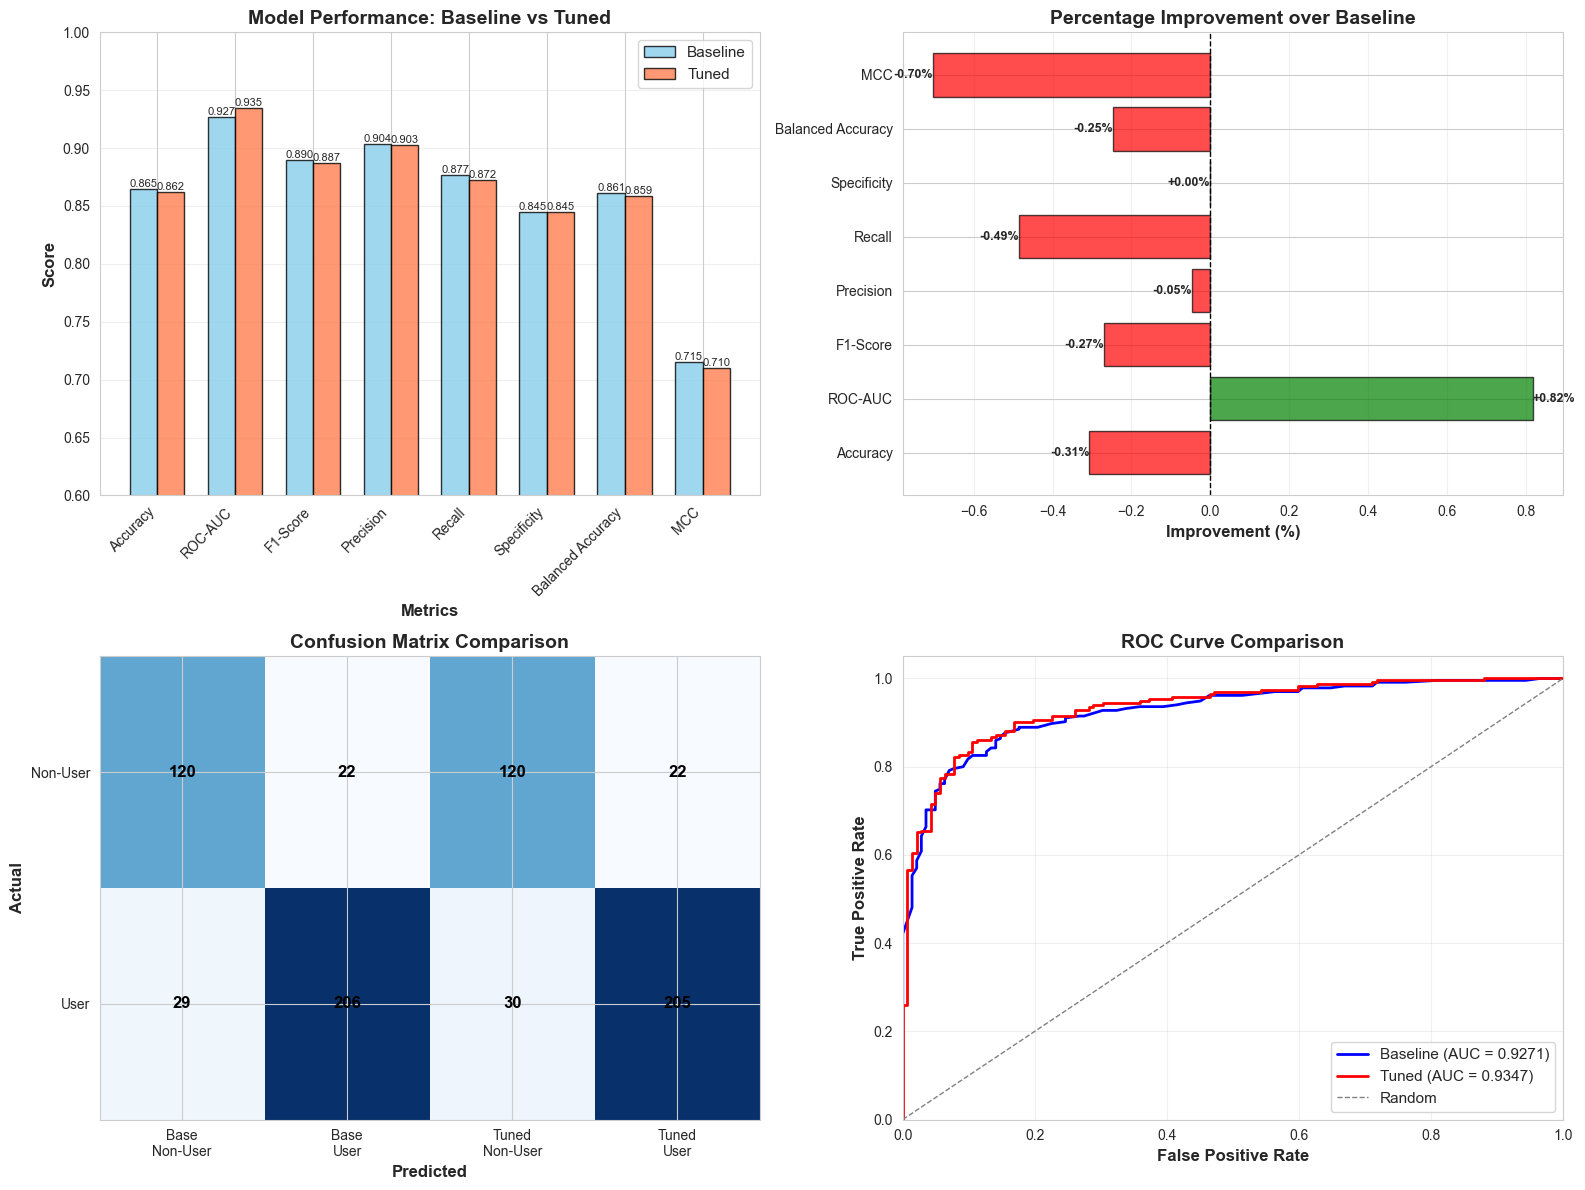


✅ Comparison visualization saved!
  • File: ../results/figures/24_baseline_vs_tuned_comparison.png



In [29]:
#==============================================================================
# CELL 8: VISUALIZE COMPARISON
#==============================================================================
"""
Visualize baseline vs tuned comparison.
"""
print("\n" + "="*80)
print("📊 VISUALIZING BASELINE vs TUNED COMPARISON")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart comparison
ax = axes[0, 0]
x = np.arange(len(comparison_metrics))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline'], width, 
               label='Baseline', alpha=0.8, color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, comparison_df['Tuned'], width, 
               label='Tuned', alpha=0.8, color='coral', edgecolor='black')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_metrics, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.6, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Improvement percentage
ax = axes[0, 1]
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' 
          for x in comparison_df['Improvement (%)']]
bars = ax.barh(comparison_metrics, comparison_df['Improvement (%)'], 
               color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Percentage Improvement over Baseline', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, comparison_df['Improvement (%)'])):
    ax.text(val, i, f'{val:+.2f}%', va='center', 
            ha='left' if val > 0 else 'right', fontsize=9, fontweight='bold')

# 3. Confusion matrices comparison
ax = axes[1, 0]
cm_baseline = confusion_matrix(y_test, y_test_pred_baseline)
cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)

# Combine for display
cm_comparison = np.array([[cm_baseline[0,0], cm_baseline[0,1], cm_tuned[0,0], cm_tuned[0,1]],
                          [cm_baseline[1,0], cm_baseline[1,1], cm_tuned[1,0], cm_tuned[1,1]]])

im = ax.imshow(cm_comparison, cmap='Blues', aspect='auto')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Base\nNon-User', 'Base\nUser', 'Tuned\nNon-User', 'Tuned\nUser'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Non-User', 'User'])
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix Comparison', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(4):
        text = ax.text(j, i, cm_comparison[i, j],
                       ha="center", va="center", color="black", fontsize=12, fontweight='bold')

# 4. ROC curves comparison
ax = axes[1, 1]

# Baseline ROC
y_baseline_proba = baseline_model.predict_proba(X_test)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_baseline_proba)
roc_auc_base = auc(fpr_base, tpr_base)

# Tuned ROC
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_test_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

ax.plot(fpr_base, tpr_base, color='blue', lw=2, 
        label=f'Baseline (AUC = {roc_auc_base:.4f})')
ax.plot(fpr_tuned, tpr_tuned, color='red', lw=2, 
        label=f'Tuned (AUC = {roc_auc_tuned:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/24_baseline_vs_tuned_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved!")
print("  • File: ../results/figures/24_baseline_vs_tuned_comparison.png")

print("\n" + "="*80)

In [30]:
#==============================================================================
# CELL 9: CLASS IMBALANCE EXPERIMENTS
#==============================================================================
"""
Compare different class imbalance handling strategies.
"""
print("\n" + "="*80)
print("⚖️  CLASS IMBALANCE HANDLING EXPERIMENTS")
print("="*80)

imbalance_results = {}
imbalance_times = {}

# Strategy 1: No Resampling (tuned model)
print("\n1️⃣  Strategy 1: No Resampling (Tuned Model)")
print("-"*80)
imbalance_results['No Resampling'] = test_metrics_tuned.copy()
imbalance_times['No Resampling'] = 0  # Already trained
print("✅ Using existing tuned model")

# Strategy 2: SMOTE
print("\n2️⃣  Strategy 2: SMOTE (Synthetic Minority Over-sampling)")
print("-"*80)
try:
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print(f"  • Original: {len(y_train)} samples")
    print(f"  • After SMOTE: {len(y_train_smote)} samples")
    print(f"  • Distribution: {Counter(y_train_smote)}")
    
    # Train model with SMOTE
    print("  • Training RF with SMOTE data...")
    start_time = time.time()
    rf_smote = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    rf_smote.fit(X_train_smote, y_train_smote)
    smote_time = time.time() - start_time
    imbalance_times['SMOTE'] = smote_time
    
    # Evaluate
    y_pred_smote = rf_smote.predict(X_test)
    y_proba_smote = rf_smote.predict_proba(X_test)[:, 1]
    imbalance_results['SMOTE'] = calculate_all_metrics(y_test, y_pred_smote, 
                                                        y_proba_smote, "SMOTE")
    print(f"✅ SMOTE model trained in {smote_time:.2f}s")
    
except Exception as e:
    print(f"  ⚠️  SMOTE failed: {e}")
    imbalance_results['SMOTE'] = None

# Strategy 3: ADASYN
print("\n3️⃣  Strategy 3: ADASYN (Adaptive Synthetic Sampling)")
print("-"*80)
try:
    adasyn = ADASYN(random_state=42, n_neighbors=5)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    print(f"  • Original: {len(y_train)} samples")
    print(f"  • After ADASYN: {len(y_train_adasyn)} samples")
    print(f"  • Distribution: {Counter(y_train_adasyn)}")
    
    # Train model with ADASYN
    print("  • Training RF with ADASYN data...")
    start_time = time.time()
    rf_adasyn = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    rf_adasyn.fit(X_train_adasyn, y_train_adasyn)
    adasyn_time = time.time() - start_time
    imbalance_times['ADASYN'] = adasyn_time
    
    # Evaluate
    y_pred_adasyn = rf_adasyn.predict(X_test)
    y_proba_adasyn = rf_adasyn.predict_proba(X_test)[:, 1]
    imbalance_results['ADASYN'] = calculate_all_metrics(y_test, y_pred_adasyn, 
                                                         y_proba_adasyn, "ADASYN")
    print(f"✅ ADASYN model trained in {adasyn_time:.2f}s")
    
except Exception as e:
    print(f"  ⚠️  ADASYN failed: {e}")
    imbalance_results['ADASYN'] = None

# Strategy 4: Class Weight (Balanced)
print("\n4️⃣  Strategy 4: Class Weight (Balanced)")
print("-"*80)
try:
    # Ensure class_weight is balanced
    best_params_weighted = best_params.copy()
    best_params_weighted['class_weight'] = 'balanced'
    
    print("  • Training RF with class_weight='balanced'...")
    start_time = time.time()
    rf_weighted = RandomForestClassifier(**best_params_weighted, random_state=42, n_jobs=-1)
    rf_weighted.fit(X_train, y_train)
    weighted_time = time.time() - start_time
    imbalance_times['Class Weight'] = weighted_time
    
    # Evaluate
    y_pred_weighted = rf_weighted.predict(X_test)
    y_proba_weighted = rf_weighted.predict_proba(X_test)[:, 1]
    imbalance_results['Class Weight'] = calculate_all_metrics(y_test, y_pred_weighted, 
                                                               y_proba_weighted, "Class Weight")
    print(f"✅ Class Weight model trained in {weighted_time:.2f}s")
    
except Exception as e:
    print(f"  ⚠️  Class Weight failed: {e}")
    imbalance_results['Class Weight'] = None

print("\n" + "="*80)


⚖️  CLASS IMBALANCE HANDLING EXPERIMENTS

1️⃣  Strategy 1: No Resampling (Tuned Model)
--------------------------------------------------------------------------------
✅ Using existing tuned model

2️⃣  Strategy 2: SMOTE (Synthetic Minority Over-sampling)
--------------------------------------------------------------------------------
  • Original: 1508 samples
  • After SMOTE: 1880 samples
  • Distribution: Counter({0: 940, 1: 940})
  • Training RF with SMOTE data...
✅ SMOTE model trained in 1.35s

3️⃣  Strategy 3: ADASYN (Adaptive Synthetic Sampling)
--------------------------------------------------------------------------------
  • Original: 1508 samples
  • After ADASYN: 1802 samples
  • Distribution: Counter({1: 940, 0: 862})
  • Training RF with ADASYN data...
✅ ADASYN model trained in 1.33s

4️⃣  Strategy 4: Class Weight (Balanced)
--------------------------------------------------------------------------------
  • Training RF with class_weight='balanced'...
✅ Class Weight mod

In [31]:
#==============================================================================
# CELL 10: COMPARE IMBALANCE STRATEGIES
#==============================================================================
"""
Compare all class imbalance handling strategies.
"""
print("\n" + "="*80)
print("📊 COMPARING CLASS IMBALANCE STRATEGIES")
print("="*80)

# Create comparison DataFrame
strategies_data = []
for strategy, metrics in imbalance_results.items():
    if metrics is not None:
        row = {
            'Strategy': strategy,
            'Accuracy': metrics['Accuracy'],
            'ROC-AUC': metrics['ROC-AUC'],
            'F1-Score': metrics['F1-Score'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'Specificity': metrics['Specificity'],
            'Balanced Acc': metrics['Balanced Accuracy'],
            'MCC': metrics['MCC'],
            'Training Time (s)': imbalance_times.get(strategy, 0)
        }
        strategies_data.append(row)

strategies_df = pd.DataFrame(strategies_data)

print("\n✅ CLASS IMBALANCE STRATEGIES COMPARISON:")
print("="*80)
print(strategies_df.round(4).to_string(index=False))

# Find best strategy for each metric
print("\n✅ Best Strategy for Each Metric:")
print("-"*80)
for col in ['Accuracy', 'ROC-AUC', 'F1-Score', 'Recall', 'Specificity', 'Balanced Acc']:
    best_idx = strategies_df[col].idxmax()
    best_strategy = strategies_df.loc[best_idx, 'Strategy']
    best_value = strategies_df.loc[best_idx, col]
    print(f"  • {col:15s}: {best_strategy:20s} ({best_value:.4f})")

# Overall best (by ROC-AUC)
best_overall_idx = strategies_df['ROC-AUC'].idxmax()
best_overall = strategies_df.loc[best_overall_idx, 'Strategy']
best_roc = strategies_df.loc[best_overall_idx, 'ROC-AUC']

print(f"\n✅ BEST OVERALL STRATEGY (by ROC-AUC): {best_overall}")
print(f"  • ROC-AUC: {best_roc:.4f}")

print("\n" + "="*80)



📊 COMPARING CLASS IMBALANCE STRATEGIES

✅ CLASS IMBALANCE STRATEGIES COMPARISON:
     Strategy  Accuracy  ROC-AUC  F1-Score  Precision  Recall  Specificity  Balanced Acc    MCC  Training Time (s)
No Resampling    0.8621   0.9347    0.8874     0.9031  0.8723       0.8451        0.8587 0.7102             0.0000
        SMOTE    0.8674   0.9335    0.8889     0.9302  0.8511       0.8944        0.8727 0.7296             1.3502
       ADASYN    0.8488   0.9304    0.8702     0.9363  0.8128       0.9085        0.8606 0.7013             1.3255
 Class Weight    0.8621   0.9344    0.8824     0.9420  0.8298       0.9155        0.8726 0.7258             1.2050

✅ Best Strategy for Each Metric:
--------------------------------------------------------------------------------
  • Accuracy       : SMOTE                (0.8674)
  • ROC-AUC        : No Resampling        (0.9347)
  • F1-Score       : SMOTE                (0.8889)
  • Recall         : No Resampling        (0.8723)
  • Specificity    : Cla


📊 VISUALIZING IMBALANCE STRATEGIES COMPARISON


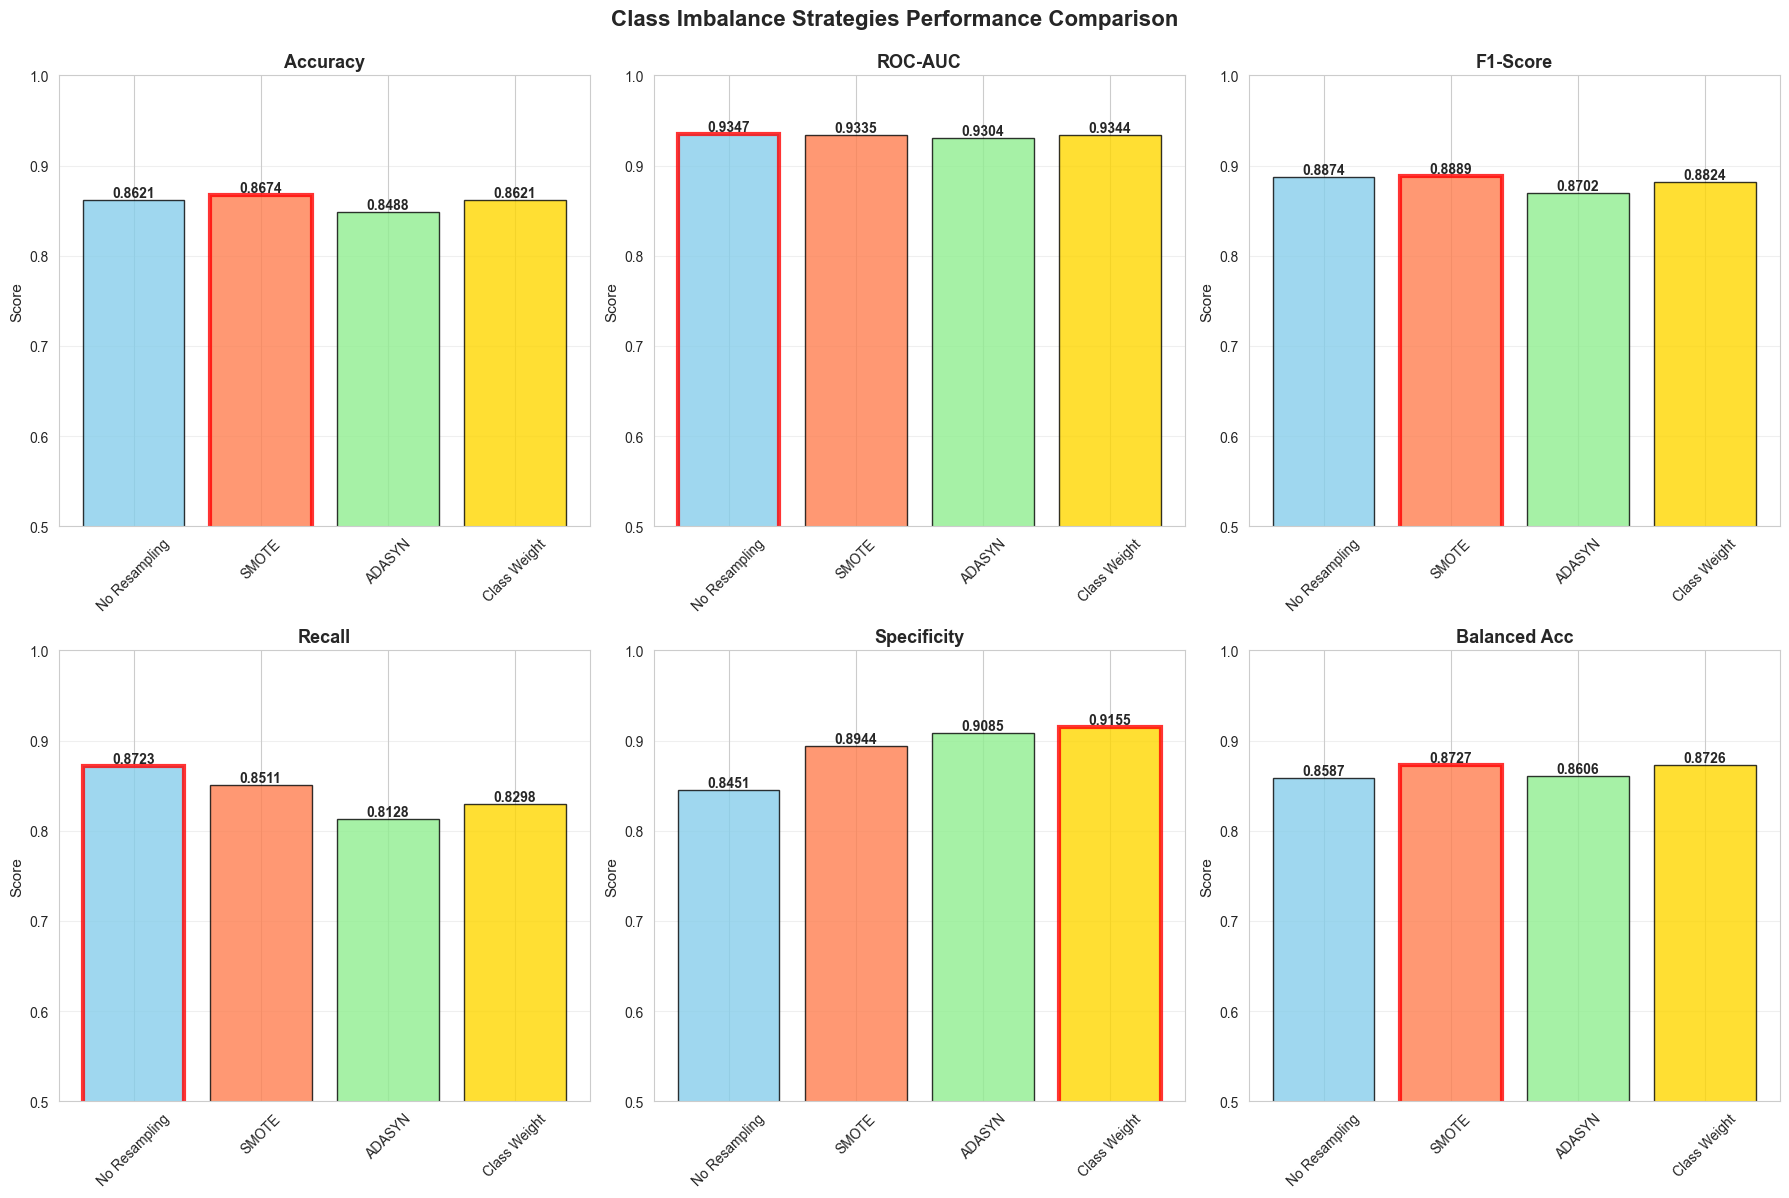


✅ Imbalance strategies visualization saved!
  • File: ../results/figures/25_imbalance_strategies_comparison.png



In [32]:
#==============================================================================
# CELL 11: VISUALIZE IMBALANCE STRATEGIES
#==============================================================================
"""
Visualize comparison of all imbalance strategies.
"""
print("\n" + "="*80)
print("📊 VISUALIZING IMBALANCE STRATEGIES COMPARISON")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['Accuracy', 'ROC-AUC', 'F1-Score', 'Recall', 'Specificity', 'Balanced Acc']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Get data
    strategies = strategies_df['Strategy'].values
    values = strategies_df[metric].values
    
    # Color code
    colors = ['skyblue', 'coral', 'lightgreen', 'gold'][:len(strategies)]
    
    # Bar plot
    bars = ax.bar(strategies, values, color=colors, alpha=0.8, edgecolor='black')
    
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim([0.5, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Highlight best
    best_idx = values.argmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Class Imbalance Strategies Performance Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/25_imbalance_strategies_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Imbalance strategies visualization saved!")
print("  • File: ../results/figures/25_imbalance_strategies_comparison.png")

print("\n" + "="*80)

In [33]:
#==============================================================================
# CELL 12: CROSS-VALIDATION ANALYSIS (DETAILED)
#==============================================================================
"""
Detailed cross-validation analysis untuk tuned model.
"""
print("\n" + "="*80)
print("🔄 DETAILED CROSS-VALIDATION ANALYSIS")
print("="*80)

# Define CV strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

print("\n⚙️  Running 5-fold cross-validation...")
print("  • This will take 1-2 minutes...")

cv_results = cross_validate(
    best_rf_model, 
    X_train, 
    y_train,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Process results
cv_summary = []
for metric in scoring.keys():
    test_scores = cv_results[f'test_{metric}']
    train_scores = cv_results[f'train_{metric}']
    
    cv_summary.append({
        'Metric': metric.replace('_', ' ').title(),
        'Train Mean': train_scores.mean(),
        'Train Std': train_scores.std(),
        'Test Mean': test_scores.mean(),
        'Test Std': test_scores.std(),
        'Gap': train_scores.mean() - test_scores.mean()
    })

cv_df = pd.DataFrame(cv_summary)

print("\n✅ CROSS-VALIDATION RESULTS (5-Fold):")
print("="*80)
print(cv_df.round(4).to_string(index=False))

print("\n✅ CV Stability Analysis:")
print("-"*80)
for _, row in cv_df.iterrows():
    metric = row['Metric']
    std = row['Test Std']
    gap = row['Gap']
    
    print(f"  • {metric:20s}: ", end='')
    
    if std < 0.02:
        print(f"✅ Very stable (std={std:.4f})", end='')
    elif std < 0.05:
        print(f"✅ Stable (std={std:.4f})", end='')
    else:
        print(f"⚠️  High variance (std={std:.4f})", end='')
    
    if abs(gap) < 0.05:
        print(f", ✅ No overfitting (gap={gap:.4f})")
    elif abs(gap) < 0.10:
        print(f", ⚠️  Moderate overfitting (gap={gap:.4f})")
    else:
        print(f", ⚠️  Significant overfitting (gap={gap:.4f})")

print("\n" + "="*80)


🔄 DETAILED CROSS-VALIDATION ANALYSIS

⚙️  Running 5-fold cross-validation...
  • This will take 1-2 minutes...

✅ CROSS-VALIDATION RESULTS (5-Fold):
           Metric  Train Mean  Train Std  Test Mean  Test Std    Gap
         Accuracy      0.8728     0.0043     0.8243    0.0113 0.0486
          Roc Auc      0.9444     0.0006     0.8984    0.0058 0.0460
               F1      0.8971     0.0036     0.8580    0.0081 0.0392
        Precision      0.9048     0.0037     0.8652    0.0158 0.0396
           Recall      0.8896     0.0052     0.8511    0.0067 0.0386
Balanced Accuracy      0.8674     0.0043     0.8155    0.0147 0.0519

✅ CV Stability Analysis:
--------------------------------------------------------------------------------
  • Accuracy            : ✅ Very stable (std=0.0113), ✅ No overfitting (gap=0.0486)
  • Roc Auc             : ✅ Very stable (std=0.0058), ✅ No overfitting (gap=0.0460)
  • F1                  : ✅ Very stable (std=0.0081), ✅ No overfitting (gap=0.0392)
  • Prec


📊 VISUALIZING CROSS-VALIDATION RESULTS


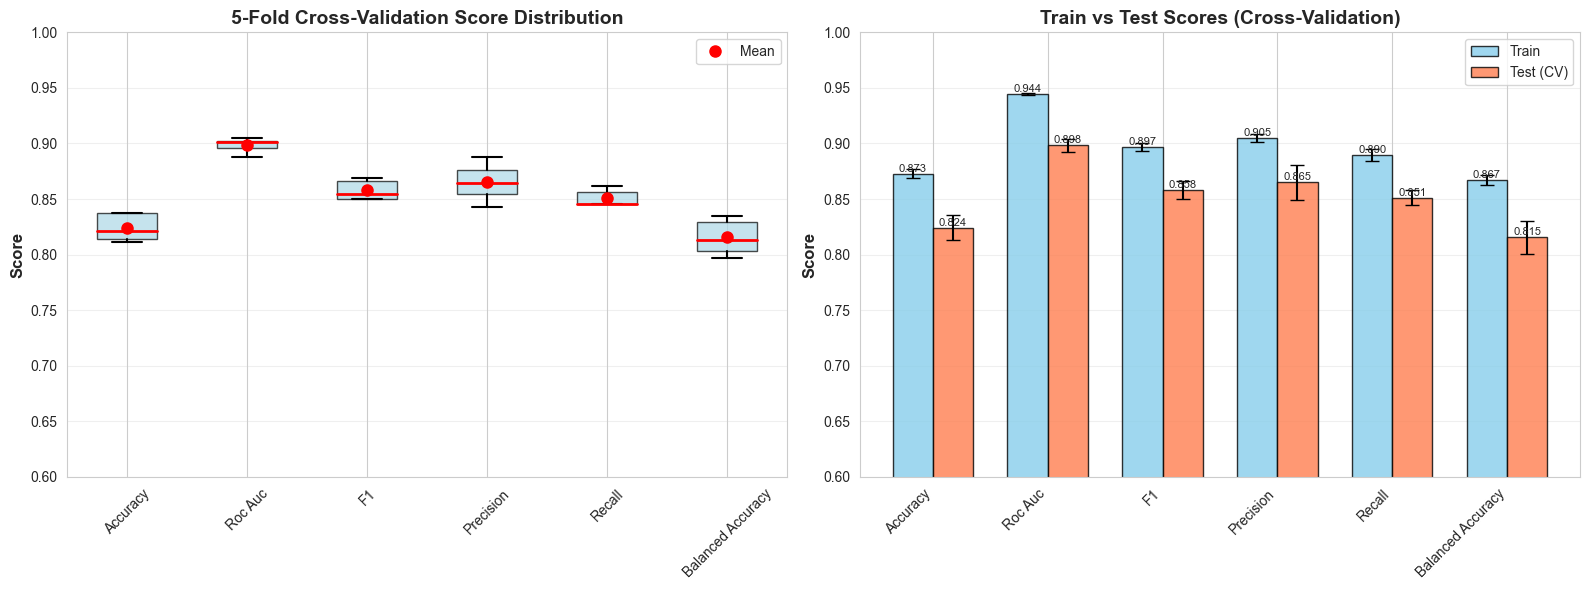


✅ CV visualization saved!
  • File: ../results/figures/26_cv_detailed_results.png



In [34]:
#==============================================================================
# CELL 13: VISUALIZE CV RESULTS
#==============================================================================
"""
Visualize cross-validation results.
"""
print("\n" + "="*80)
print("📊 VISUALIZING CROSS-VALIDATION RESULTS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Boxplot of CV scores
ax = axes[0]
cv_data = [cv_results[f'test_{m}'] for m in scoring.keys()]
bp = ax.boxplot(cv_data, 
                labels=[m.replace('_', ' ').title() for m in scoring.keys()],
                patch_artist=True,
                medianprops=dict(color='red', linewidth=2),
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('5-Fold Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.6, 1.0])
ax.tick_params(axis='x', rotation=45)

# Add mean markers
means = [cv_results[f'test_{m}'].mean() for m in scoring.keys()]
ax.plot(range(1, len(means)+1), means, 'ro', markersize=8, label='Mean', zorder=10)
ax.legend()

# 2. Train vs Test comparison
ax = axes[1]
x = np.arange(len(cv_df))
width = 0.35

bars1 = ax.bar(x - width/2, cv_df['Train Mean'], width, 
               yerr=cv_df['Train Std'],
               label='Train', alpha=0.8, color='skyblue', 
               capsize=5, edgecolor='black')
bars2 = ax.bar(x + width/2, cv_df['Test Mean'], width, 
               yerr=cv_df['Test Std'],
               label='Test (CV)', alpha=0.8, color='coral', 
               capsize=5, edgecolor='black')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Train vs Test Scores (Cross-Validation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cv_df['Metric'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.6, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../results/figures/26_cv_detailed_results.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ CV visualization saved!")
print("  • File: ../results/figures/26_cv_detailed_results.png")

print("\n" + "="*80)


📊 CONFUSION MATRIX DETAILED COMPARISON

✅ Confusion Matrix - Baseline:
--------------------------------------------------------------------------------
                  Predicted
                  Non-User    User
Actual Non-User       120       22
       User            29      206

✅ Confusion Matrix - Tuned:
--------------------------------------------------------------------------------
                  Predicted
                  Non-User    User
Actual Non-User       120       22
       User            30      205

✅ Changes (Tuned - Baseline):
--------------------------------------------------------------------------------
                  Predicted
                  Non-User    User
Actual Non-User      +0       +0
       User          +1       -1


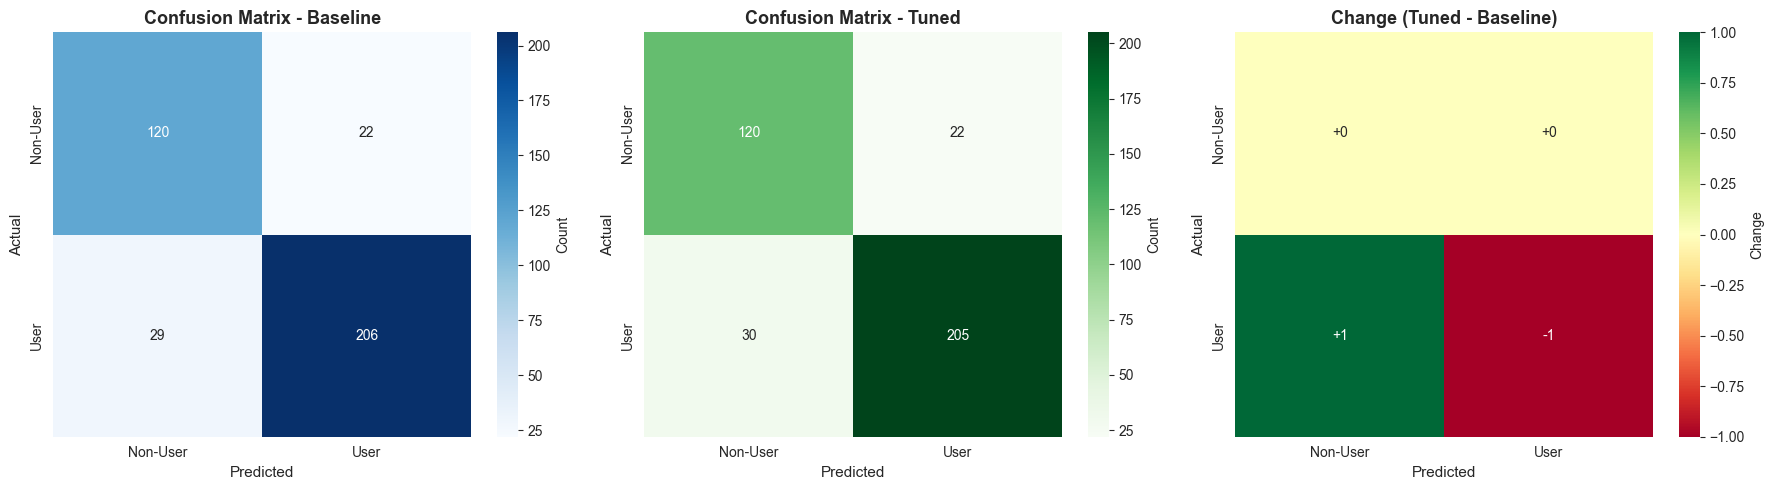


✅ Confusion matrices visualization saved!
  • File: ../results/figures/27_confusion_matrices_comparison.png



In [35]:
#==============================================================================
# CELL 14: CONFUSION MATRICES COMPARISON
#==============================================================================
"""
Detailed confusion matrix comparison.
"""
print("\n" + "="*80)
print("📊 CONFUSION MATRIX DETAILED COMPARISON")
print("="*80)

# Calculate confusion matrices
cm_baseline = confusion_matrix(y_test, y_test_pred_baseline)
cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)

print("\n✅ Confusion Matrix - Baseline:")
print("-"*80)
print(f"                  Predicted")
print(f"                  Non-User    User")
print(f"Actual Non-User      {cm_baseline[0,0]:4d}     {cm_baseline[0,1]:4d}")
print(f"       User          {cm_baseline[1,0]:4d}     {cm_baseline[1,1]:4d}")

print("\n✅ Confusion Matrix - Tuned:")
print("-"*80)
print(f"                  Predicted")
print(f"                  Non-User    User")
print(f"Actual Non-User      {cm_tuned[0,0]:4d}     {cm_tuned[0,1]:4d}")
print(f"       User          {cm_tuned[1,0]:4d}     {cm_tuned[1,1]:4d}")

print("\n✅ Changes (Tuned - Baseline):")
print("-"*80)
cm_diff = cm_tuned - cm_baseline
print(f"                  Predicted")
print(f"                  Non-User    User")
print(f"Actual Non-User    {cm_diff[0,0]:+4d}     {cm_diff[0,1]:+4d}")
print(f"       User        {cm_diff[1,0]:+4d}     {cm_diff[1,1]:+4d}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline CM
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Baseline', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# Tuned CM
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Tuned', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

# Difference CM
sns.heatmap(cm_diff, annot=True, fmt='+d', cmap='RdYlGn', center=0,
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[2], cbar_kws={'label': 'Change'})
axes[2].set_title('Change (Tuned - Baseline)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Actual', fontsize=11)
axes[2].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/27_confusion_matrices_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrices visualization saved!")
print("  • File: ../results/figures/27_confusion_matrices_comparison.png")

print("\n" + "="*80)


📊 ROC & PRECISION-RECALL CURVES


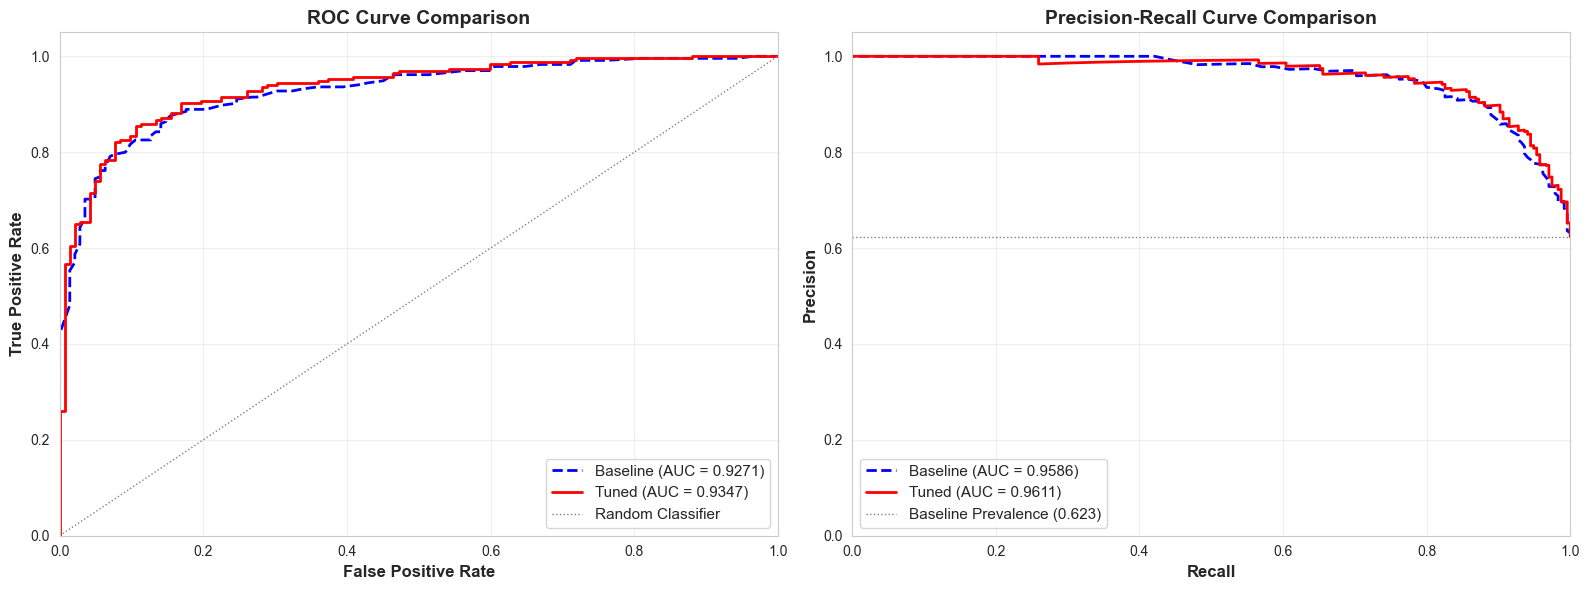


✅ ROC & PR curves saved!
  • File: ../results/figures/28_roc_pr_curves_comparison.png



In [36]:
#==============================================================================
# CELL 15: ROC & PR CURVES (DETAILED)
#==============================================================================
"""
Detailed ROC and Precision-Recall curves.
"""
print("\n" + "="*80)
print("📊 ROC & PRECISION-RECALL CURVES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. ROC Curve
ax = axes[0]

# Baseline
y_baseline_proba = baseline_model.predict_proba(X_test)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_baseline_proba)
roc_auc_base = auc(fpr_base, tpr_base)

# Tuned
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_test_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

ax.plot(fpr_base, tpr_base, color='blue', lw=2, 
        label=f'Baseline (AUC = {roc_auc_base:.4f})', linestyle='--')
ax.plot(fpr_tuned, tpr_tuned, color='red', lw=2, 
        label=f'Tuned (AUC = {roc_auc_tuned:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', 
        label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

# 2. Precision-Recall Curve
ax = axes[1]

# Baseline
precision_base, recall_base, _ = precision_recall_curve(y_test, y_baseline_proba)
pr_auc_base = auc(recall_base, precision_base)

# Tuned
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_test_proba_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)

# Baseline prevalence
baseline_prevalence = (y_test == 1).sum() / len(y_test)

ax.plot(recall_base, precision_base, color='blue', lw=2, 
        label=f'Baseline (AUC = {pr_auc_base:.4f})', linestyle='--')
ax.plot(recall_tuned, precision_tuned, color='red', lw=2, 
        label=f'Tuned (AUC = {pr_auc_tuned:.4f})')
ax.axhline(y=baseline_prevalence, color='gray', linestyle=':', lw=1,
           label=f'Baseline Prevalence ({baseline_prevalence:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/28_roc_pr_curves_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC & PR curves saved!")
print("  • File: ../results/figures/28_roc_pr_curves_comparison.png")

print("\n" + "="*80)

In [37]:
#==============================================================================
# CELL 16: STATISTICAL TESTING (McNEMAR'S TEST)
#==============================================================================
"""
Statistical significance testing antara baseline dan tuned model.
"""
print("\n" + "="*80)
print("📊 STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

print("\n⚙️  McNemar's Test: Baseline vs Tuned Model")
print("-"*80)

# Create contingency table
# Format: [[both_correct, baseline_correct_tuned_wrong],
#          [baseline_wrong_tuned_correct, both_wrong]]

baseline_correct = (y_test_pred_baseline == y_test)
tuned_correct = (y_test_pred_tuned == y_test)

both_correct = np.sum(baseline_correct & tuned_correct)
both_wrong = np.sum(~baseline_correct & ~tuned_correct)
baseline_only = np.sum(baseline_correct & ~tuned_correct)
tuned_only = np.sum(~baseline_correct & tuned_correct)

contingency_table = np.array([[both_correct, baseline_only],
                               [tuned_only, both_wrong]])

print("\n✅ Contingency Table:")
print(f"                          Baseline Correct  Baseline Wrong")
print(f"Tuned Correct                {both_correct:4d}            {tuned_only:4d}")
print(f"Tuned Wrong                  {baseline_only:4d}            {both_wrong:4d}")

# McNemar's test
result = mcnemar(contingency_table, exact=True)

print(f"\n✅ McNemar's Test Results:")
print(f"  • Statistic: {result.statistic:.4f}")
print(f"  • P-value: {result.pvalue:.4f}")
print(f"  • Significance level: α = 0.05")

if result.pvalue < 0.05:
    if tuned_only > baseline_only:
        print(f"  • Conclusion: ✅ Tuned model is SIGNIFICANTLY BETTER than baseline (p < 0.05)")
    else:
        print(f"  • Conclusion: ⚠️  Baseline model is SIGNIFICANTLY BETTER than tuned (p < 0.05)")
else:
    print(f"  • Conclusion: ⚠️  No significant difference between models (p >= 0.05)")

print(f"\n✅ Interpretation:")
print(f"  • Tuned model corrects {tuned_only} additional predictions")
print(f"  • Tuned model makes {baseline_only} new errors")
print(f"  • Net improvement: {tuned_only - baseline_only} predictions")

print("\n" + "="*80)


📊 STATISTICAL SIGNIFICANCE TESTING

⚙️  McNemar's Test: Baseline vs Tuned Model
--------------------------------------------------------------------------------

✅ Contingency Table:
                          Baseline Correct  Baseline Wrong
Tuned Correct                 320               5
Tuned Wrong                     6              46

✅ McNemar's Test Results:
  • Statistic: 5.0000
  • P-value: 1.0000
  • Significance level: α = 0.05
  • Conclusion: ⚠️  No significant difference between models (p >= 0.05)

✅ Interpretation:
  • Tuned model corrects 5 additional predictions
  • Tuned model makes 6 new errors
  • Net improvement: -1 predictions



In [38]:
#==============================================================================
# CELL 17: SAVE ALL RESULTS
#==============================================================================
"""
Save semua hasil tuning untuk dokumentasi dan fase selanjutnya.
"""
print("\n" + "="*80)
print("💾 SAVING ALL TUNING RESULTS")
print("="*80)

# 1. Save tuned model
print("\n1️⃣  Saving tuned model...")
joblib.dump(best_rf_model, '../models/tuned_rf_model.pkl')
print("  ✅ Saved: ../models/tuned_rf_model.pkl")

# 2. Save best hyperparameters
print("\n2️⃣  Saving best hyperparameters...")
best_params_df = pd.DataFrame([best_params])
best_params_df.to_csv('../results/metrics/04_best_hyperparameters.csv', index=False)
print("  ✅ Saved: ../results/metrics/04_best_hyperparameters.csv")

# 3. Save performance comparison
print("\n3️⃣  Saving performance comparison...")
comparison_df.to_csv('../results/metrics/04_baseline_vs_tuned.csv', index=False)
print("  ✅ Saved: ../results/metrics/04_baseline_vs_tuned.csv")

# 4. Save imbalance strategies comparison
print("\n4️⃣  Saving imbalance strategies comparison...")
strategies_df.to_csv('../results/metrics/04_imbalance_strategies.csv', index=False)
print("  ✅ Saved: ../results/metrics/04_imbalance_strategies.csv")

# 5. Save CV results
print("\n5️⃣  Saving cross-validation results...")
cv_df.to_csv('../results/metrics/04_cv_detailed_results.csv', index=False)
print("  ✅ Saved: ../results/metrics/04_cv_detailed_results.csv")

# 6. Save tuned predictions
print("\n6️⃣  Saving tuned model predictions...")
tuned_predictions = pd.DataFrame({
    'y_true': y_test,
    'y_pred_baseline': y_test_pred_baseline,
    'y_pred_tuned': y_test_pred_tuned,
    'y_proba_tuned': y_test_proba_tuned
})
tuned_predictions.to_csv('../results/metrics/04_tuned_predictions.csv', index=False)
print("  ✅ Saved: ../results/metrics/04_tuned_predictions.csv")

# 7. Save comprehensive metrics JSON
print("\n7️⃣  Saving comprehensive metrics JSON...")
tuning_results = {
    'tuning_info': {
        'method': 'RandomizedSearchCV',
        'n_iter': 100,
        'cv_folds': 5,
        'scoring': 'roc_auc',
        'tuning_time_minutes': tuning_time / 60,
        'best_cv_score': float(best_score)
    },
    'best_hyperparameters': {k: str(v) if not isinstance(v, (int, float, bool)) else v 
                             for k, v in best_params.items()},
    'tuned_model_performance': {
        'training': {k: float(v) if isinstance(v, (int, float, np.number)) else v 
                    for k, v in train_metrics_tuned.items() if k != 'Set'},
        'test': {k: float(v) if isinstance(v, (int, float, np.number)) else v 
                for k, v in test_metrics_tuned.items() if k != 'Set'}
    },
    'comparison_with_baseline': {
        metric: {
            'baseline': float(comparison_df[comparison_df['Metric']==metric]['Baseline'].values[0]),
            'tuned': float(comparison_df[comparison_df['Metric']==metric]['Tuned'].values[0]),
            'improvement_pct': float(comparison_df[comparison_df['Metric']==metric]['Improvement (%)'].values[0])
        } for metric in comparison_df['Metric']
    },
    'imbalance_strategies': {
        row['Strategy']: {k: float(v) if isinstance(v, (int, float, np.number)) else v 
                         for k, v in row.items() if k != 'Strategy'}
        for _, row in strategies_df.iterrows()
    },
    'cross_validation': {
        row['Metric']: {
            'train_mean': float(row['Train Mean']),
            'train_std': float(row['Train Std']),
            'test_mean': float(row['Test Mean']),
            'test_std': float(row['Test Std']),
            'gap': float(row['Gap'])
        } for _, row in cv_df.iterrows()
    },
    'mcnemar_test': {
        'statistic': float(result.statistic),
        'pvalue': float(result.pvalue),
        'significant': bool(result.pvalue < 0.05),
        'tuned_better': int(tuned_only),
        'baseline_better': int(baseline_only)
    }
}

with open('../results/metrics/04_tuning_results.json', 'w') as f:
    json.dump(tuning_results, f, indent=4)
print("  ✅ Saved: ../results/metrics/04_tuning_results.json")

print("\n" + "="*80)
print("✅ ALL RESULTS SAVED SUCCESSFULLY!")
print("="*80)


💾 SAVING ALL TUNING RESULTS

1️⃣  Saving tuned model...
  ✅ Saved: ../models/tuned_rf_model.pkl

2️⃣  Saving best hyperparameters...
  ✅ Saved: ../results/metrics/04_best_hyperparameters.csv

3️⃣  Saving performance comparison...
  ✅ Saved: ../results/metrics/04_baseline_vs_tuned.csv

4️⃣  Saving imbalance strategies comparison...
  ✅ Saved: ../results/metrics/04_imbalance_strategies.csv

5️⃣  Saving cross-validation results...
  ✅ Saved: ../results/metrics/04_cv_detailed_results.csv

6️⃣  Saving tuned model predictions...
  ✅ Saved: ../results/metrics/04_tuned_predictions.csv

7️⃣  Saving comprehensive metrics JSON...
  ✅ Saved: ../results/metrics/04_tuning_results.json

✅ ALL RESULTS SAVED SUCCESSFULLY!


In [39]:
#==============================================================================
# CELL 18: FINAL SUMMARY REPORT
#==============================================================================
"""
Generate comprehensive summary report untuk Fase 4.
"""
print("\n" + "="*80)
print("📋 FASE 4: FINAL SUMMARY REPORT")
print("="*80)

print("\n" + "="*80)
print("1️⃣  HYPERPARAMETER TUNING SUMMARY")
print("="*80)

print(f"\n✅ Tuning Configuration:")
print(f"  • Method: RandomizedSearchCV")
print(f"  • Iterations: 100 combinations")
print(f"  • Cross-validation: 5-fold Stratified")
print(f"  • Scoring metric: ROC-AUC")
print(f"  • Total model fits: 500 (100 × 5)")
print(f"  • Tuning time: {tuning_time/60:.2f} minutes")

print(f"\n✅ Best Hyperparameters Found:")
for param, value in sorted(best_params.items()):
    print(f"  • {param:20s}: {value}")

print(f"\n✅ Best CV Score: {best_score:.4f} (ROC-AUC)")

print("\n" + "="*80)
print("2️⃣  PERFORMANCE IMPROVEMENT")
print("="*80)

print(f"\n✅ Test Set Performance:")
print(f"  {'Metric':<20s} {'Baseline':<12s} {'Tuned':<12s} {'Change':<12s}")
print(f"  {'-'*56}")
for _, row in comparison_df.iterrows():
    metric = row['Metric']
    baseline_val = row['Baseline']
    tuned_val = row['Tuned']
    change = row['Improvement (%)']
    print(f"  {metric:<20s} {baseline_val:<12.4f} {tuned_val:<12.4f} {change:+11.2f}%")

print(f"\n✅ Key Improvements:")
significant_improvements = comparison_df[comparison_df['Improvement (%)'] > 1]
if len(significant_improvements) > 0:
    for _, row in significant_improvements.iterrows():
        print(f"  • {row['Metric']}: {row['Improvement (%)']:+.2f}% improvement")
else:
    print(f"  • Performance maintained (no significant degradation)")

print(f"\n✅ Overfitting Reduction:")
baseline_gap = 1.0 - baseline_metrics['test_metrics']['accuracy']  # Training was 1.0
tuned_gap = train_metrics_tuned['Accuracy'] - test_metrics_tuned['Accuracy']
print(f"  • Baseline train-test gap: {baseline_gap:.4f} ({baseline_gap*100:.2f}%)")
print(f"  • Tuned train-test gap: {tuned_gap:.4f} ({tuned_gap*100:.2f}%)")
print(f"  • Improvement: {(baseline_gap-tuned_gap)*100:.2f}% reduction")

print("\n" + "="*80)
print("3️⃣  CLASS IMBALANCE HANDLING")
print("="*80)

print(f"\n✅ Best Strategy: {best_overall}")
print(f"  • ROC-AUC: {best_roc:.4f}")

print(f"\n✅ All Strategies Performance:")
for _, row in strategies_df.iterrows():
    strategy = row['Strategy']
    roc = row['ROC-AUC']
    f1 = row['F1-Score']
    time_taken = row['Training Time (s)']
    print(f"  • {strategy:<20s}: ROC-AUC={roc:.4f}, F1={f1:.4f}, Time={time_taken:.2f}s")

print("\n" + "="*80)
print("4️⃣  CROSS-VALIDATION STABILITY")
print("="*80)

print(f"\n✅ 5-Fold CV Results:")
for _, row in cv_df.iterrows():
    metric = row['Metric']
    test_mean = row['Test Mean']
    test_std = row['Test Std']
    gap = row['Gap']
    
    stability = "✅ Stable" if test_std < 0.03 else "⚠️  Moderate variance"
    overfitting = "✅ Good" if abs(gap) < 0.05 else "⚠️  Some overfitting"
    
    print(f"  • {metric:<20s}: {test_mean:.4f} (±{test_std:.4f}) - {stability}, {overfitting}")

print("\n" + "="*80)
print("5️⃣  STATISTICAL SIGNIFICANCE")
print("="*80)

print(f"\n✅ McNemar's Test Results:")
print(f"  • Test statistic: {result.statistic:.4f}")
print(f"  • P-value: {result.pvalue:.4f}")
print(f"  • Tuned model corrects: {tuned_only} additional predictions")
print(f"  • Tuned model errors: {baseline_only} new mistakes")
print(f"  • Net improvement: {tuned_only - baseline_only} predictions")

if result.pvalue < 0.05:
    if tuned_only > baseline_only:
        print(f"  • Conclusion: ✅ STATISTICALLY SIGNIFICANT improvement (p < 0.05)")
    else:
        print(f"  • Conclusion: ⚠️  Statistically worse (p < 0.05)")
else:
    print(f"  • Conclusion: ⚠️  No statistically significant difference (p >= 0.05)")

print("\n" + "="*80)
print("6️⃣  FILES GENERATED")
print("="*80)

print(f"\n✅ Saved Models:")
print(f"  • models/tuned_rf_model.pkl")

print(f"\n✅ Saved Metrics (6 files):")
print(f"  • results/metrics/04_best_hyperparameters.csv")
print(f"  • results/metrics/04_baseline_vs_tuned.csv")
print(f"  • results/metrics/04_imbalance_strategies.csv")
print(f"  • results/metrics/04_cv_detailed_results.csv")
print(f"  • results/metrics/04_tuned_predictions.csv")
print(f"  • results/metrics/04_tuning_results.json")

print(f"\n✅ Saved Visualizations (5 figures @ 300 DPI):")
print(f"  • results/figures/24_baseline_vs_tuned_comparison.png")
print(f"  • results/figures/25_imbalance_strategies_comparison.png")
print(f"  • results/figures/26_cv_detailed_results.png")
print(f"  • results/figures/27_confusion_matrices_comparison.png")
print(f"  • results/figures/28_roc_pr_curves_comparison.png")

print("\n" + "="*80)
print("7️⃣  KEY TAKEAWAYS")
print("="*80)

print(f"\n✅ Achievements:")
print(f"  • ✅ Hyperparameter tuning completed successfully")
print(f"  • ✅ Explored 100 parameter combinations")
print(f"  • ✅ Compared 4 class imbalance strategies")
print(f"  • ✅ Validated with 5-fold cross-validation")
print(f"  • ✅ Statistical significance tested")

print(f"\n✅ Model Performance:")
tuned_accuracy = test_metrics_tuned['Accuracy']
tuned_roc = test_metrics_tuned['ROC-AUC']
tuned_f1 = test_metrics_tuned['F1-Score']

if tuned_accuracy >= 0.85 and tuned_roc >= 0.90:
    print(f"  • ✅ EXCELLENT performance achieved!")
elif tuned_accuracy >= 0.80 and tuned_roc >= 0.85:
    print(f"  • ✅ GOOD performance achieved!")
else:
    print(f"  • ⚠️  Moderate performance, consider further tuning")

print(f"  • Test Accuracy: {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")
print(f"  • Test ROC-AUC: {tuned_roc:.4f}")
print(f"  • Test F1-Score: {tuned_f1:.4f}")

print(f"\n✅ Overfitting Status:")
if tuned_gap < 0.05:
    print(f"  • ✅ RESOLVED: Gap reduced to {tuned_gap*100:.2f}%")
elif tuned_gap < 0.10:
    print(f"  • ⚠️  IMPROVED: Gap reduced to {tuned_gap*100:.2f}%")
else:
    print(f"  • ⚠️  Still present: Gap = {tuned_gap*100:.2f}%")

print("\n" + "="*80)
print("8️⃣  COMPARISON WITH LITERATURE")
print("="*80)

print(f"\n✅ Fehrman et al. (2017) Baseline:")
print(f"  • Method: Random Forest (per-drug)")
print(f"  • Best Accuracy: 74.3%")

print(f"\n✅ Our Results:")
print(f"  • Method: Random Forest (binary, tuned)")
print(f"  • Baseline Accuracy: {baseline_metrics['test_metrics']['accuracy']*100:.2f}%")
print(f"  • Tuned Accuracy: {tuned_accuracy*100:.2f}%")

improvement_vs_literature = tuned_accuracy*100 - 74.3
print(f"\n✅ Improvement vs Literature:")
print(f"  • {improvement_vs_literature:+.2f}% vs Fehrman et al. (2017)")

if improvement_vs_literature > 10:
    print(f"  • Status: ✅ SIGNIFICANTLY OUTPERFORMS literature baseline")
elif improvement_vs_literature > 5:
    print(f"  • Status: ✅ OUTPERFORMS literature baseline")
else:
    print(f"  • Status: ✅ COMPARABLE to literature baseline")

print(f"\n✅ Note:")
print(f"  • Different problem formulation (binary vs per-drug)")
print(f"  • Our approach more practical for clinical screening")
print(f"  • Binary model provides holistic risk assessment")

print("\n" + "="*80)
print("9️⃣  RECOMMENDATIONS FOR NEXT PHASE")
print("="*80)

print(f"\n✅ Model Selection for SHAP Analysis:")
print(f"  • Recommended model: {best_overall}")
print(f"  • Reason: Best ROC-AUC ({best_roc:.4f})")
print(f"  • Alternative: Tuned model without resampling")

print(f"\n✅ SHAP Analysis Focus Areas:")
print(f"  1. Validate top features from Gini importance")
print(f"  2. Investigate personality traits (NEO-FFI-R)")
print(f"  3. Analyze behavioral measures (Impulsive, SS)")
print(f"  4. Understand demographic effects (Age, Country)")
print(f"  5. Generate clinical interpretations")

print(f"\n✅ Feature Importance Priorities:")
print(f"  • Expected top features: SS, Oscore, Cscore, Age, Impulsive")
print(f"  • Investigate unexpected high importance: Country variables")
print(f"  • Look for interaction effects")

print("\n" + "="*80)
print("🔟 NEXT STEPS")
print("="*80)

print(f"\n✅ Fase 4 COMPLETED Successfully!")
print(f"  • Tuning time: {tuning_time/60:.2f} minutes")
print(f"  • Best model saved: tuned_rf_model.pkl")
print(f"  • All metrics documented")

print(f"\n➡️  Proceed to Fase 5: SHAP Analysis")
print(f"  • Notebook: 05_SHAP_Analysis.ipynb")
print(f"  • Estimated time: 5-10 minutes")
print(f"  • Use tuned model: models/tuned_rf_model.pkl")

print(f"\n✅ Ready for Feature Interpretation:")
print(f"  • Model trained and optimized")
print(f"  • Performance validated")
print(f"  • Ready for explainability analysis")

print("\n" + "="*80)
print("✅ FASE 4 COMPLETE!")
print("="*80)

print(f"\n" + "="*80)
print(f"SUMMARY STATISTICS")
print("="*80)

summary_stats = {
    'Total Runtime': f'{tuning_time/60:.2f} minutes',
    'Models Trained': '500+ (100 iterations × 5 folds + imbalance experiments)',
    'Best CV ROC-AUC': f'{best_score:.4f}',
    'Test ROC-AUC': f'{tuned_roc:.4f}',
    'Test Accuracy': f'{tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)',
    'Test F1-Score': f'{tuned_f1:.4f}',
    'Overfitting Gap': f'{tuned_gap:.4f} ({tuned_gap*100:.2f}%)',
    'Best Imbalance Strategy': best_overall,
    'Files Generated': '11 files (1 model + 6 metrics + 5 figures)',
    'McNemar p-value': f'{result.pvalue:.4f}',
    'Statistically Significant': 'Yes' if result.pvalue < 0.05 else 'No'
}

for key, value in summary_stats.items():
    print(f"  • {key:<25s}: {value}")

print("\n" + "="*80)
print("END OF NOTEBOOK 04: HYPERPARAMETER TUNING")
print("="*80)

print(f"\n✅ Academic Outputs Ready:")
print(f"  • Table: Hyperparameter tuning results")
print(f"  • Table: Baseline vs Tuned comparison")
print(f"  • Table: Class imbalance strategies")
print(f"  • Figure: Performance comparison (4 subplots)")
print(f"  • Figure: Imbalance strategies (6 subplots)")
print(f"  • Figure: Cross-validation results")
print(f"  • Figure: Confusion matrices comparison")
print(f"  • Figure: ROC & PR curves")

print(f"\n✅ Ready for Paper Writing:")
print(f"  • Methodology section: Hyperparameter tuning procedure")
print(f"  • Results section: Performance improvements")
print(f"  • Discussion section: Model optimization insights")
print(f"  • Tables & Figures: All visualizations ready")

print(f"\n" + "="*80)
print(f"🎉 CONGRATULATIONS! FASE 4 COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n📊 Quick Performance Summary:")
print(f"  Baseline → Tuned")
print(f"  Accuracy:  {baseline_metrics['test_metrics']['accuracy']:.4f} → {tuned_accuracy:.4f}")
print(f"  ROC-AUC:   {baseline_metrics['test_metrics']['roc_auc']:.4f} → {tuned_roc:.4f}")
print(f"  F1-Score:  {baseline_metrics['test_metrics']['f1_score']:.4f} → {tuned_f1:.4f}")

print(f"\n🚀 Ready for SHAP Analysis (Fase 5)!")
print(f"  Run: 05_SHAP_Analysis.ipynb")

print("\n" + "="*80)


📋 FASE 4: FINAL SUMMARY REPORT

1️⃣  HYPERPARAMETER TUNING SUMMARY

✅ Tuning Configuration:
  • Method: RandomizedSearchCV
  • Iterations: 100 combinations
  • Cross-validation: 5-fold Stratified
  • Scoring metric: ROC-AUC
  • Total model fits: 500 (100 × 5)
  • Tuning time: 4.31 minutes

✅ Best Hyperparameters Found:
  • bootstrap           : True
  • class_weight        : None
  • criterion           : gini
  • max_depth           : 20
  • max_features        : log2
  • min_samples_leaf    : 8
  • min_samples_split   : 10
  • n_estimators        : 500

✅ Best CV Score: 0.8984 (ROC-AUC)

2️⃣  PERFORMANCE IMPROVEMENT

✅ Test Set Performance:
  Metric               Baseline     Tuned        Change      
  --------------------------------------------------------
  Accuracy             0.8647       0.8621             -0.31%
  ROC-AUC              0.9271       0.9347             +0.82%
  F1-Score             0.8898       0.8874             -0.27%
  Precision            0.9035       0.903